# Hypertrophic Cardiomyopathy Genes Cross-Validation
##### Selin Kubali
##### 12/13/2023
## Goal
Find out whether we can distinguish the HCM risk of bottom 25% and top 25% of missense and deleterious variant carriers in key hypertrophic cardiomyopathy-related genes.

#### How the code functions
Use cross-validation to fit a Cox-PH model and predict hazard scores. Then isolate the bottom 25% and top 25% of carriers by hazard score and calculate whether there is a statistically significant difference in HCM between them use the Mann-Whitney U test.

Cross-validation is done by splitting on variant data, to ensure there are an equal number of variants in each fold and prevent overfitting on high-frequency variants.

#### Inputs
Lifelines files - from running generate_extracts_gnomAD.ipynb on UKBiobank in Cassa Lab Shared Project/selected_genes/hcm/notebooks. Stored in Cassa Lab Shared Project/selected_genes/hcm/lifelines_data. 
Variant data files - from running vep_processing.ipynb on UKBiobank in Cassa Lab Shared Project/selected_genes/hcm/notebooks. Stored in Cassa Lab Shared Project/selected_genes/hcm/parsed_vep_files

#### Note
Two HCM related genes - DES and PLN - were eliminated for having too few variants to converge.
PTPN11, TNNI3, and TTR each have few cases of HCM with missense or deleterious variants, which may harm convergence.

In [3]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from sklearn.model_selection import KFold
from statsmodels.stats.multitest import multipletests
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt 
import seaborn as sns
from seaborn import stripplot

In [4]:
def cross_val(gene):
        cph = CoxPHFitter(penalizer=0.0000001)
        # load lifelines file
        file_name=gene+'.csv'
        lifelines_data = pd.read_csv("/Users/uriel/Downloads/work_temp/cross_val_lifelines/"+file_name, dtype={
                'is_family_hist':'boolean',
                'is_hcm':'boolean'
                })

        # load variant data file
        file_name=gene+'.csv'
        variant_data = pd.read_csv("/Users/uriel/Downloads/work_temp/variant_files/"+file_name)


        clinvar_df = pd.read_csv("/Users/uriel/Downloads/work_temp/variant_summary.txt", sep = '\t')
        clinvar_df = clinvar_df.rename(columns={"Chromosome": "Chrom", "Start": "Pos", "ReferenceAlleleVCF": "Ref", "AlternateAlleleVCF": "Alt"})
        clinvar_df = clinvar_df[["Name", "Chrom", "Pos", "Ref", "Alt", "ClinicalSignificance"]]
        clinvar_variant_df = pd.merge(variant_data, clinvar_df, how = 'left', on = ['Pos', 'Ref', 'Alt'])
        clinvar_variant_df = clinvar_variant_df.rename(columns={"Name_x": "Name"})
        clinvar_variant_df = clinvar_variant_df[["Name", "ClinicalSignificance"]]
        lifelines_data_with_clin_sign = pd.merge(clinvar_variant_df, lifelines_data, how="right", on = ['Name'])
        lifelines_data_with_clin_sign = lifelines_data_with_clin_sign.drop(['Name', 'Carrier', 'index', 'am_pathogenicity'], axis = 1)


        variant_data = variant_data[['Name']]
        variant_data['var_index'] = variant_data.index





        # set lifelines data index to variant data index
        lifelines_data = variant_data.merge(lifelines_data, how="outer")
        lifelines_data.set_index("var_index")

        # clean lifelines file; set pathogenicity for deleterious variants to 1
        lifelines_data.loc[lifelines_data['deleterious'] == 1, 'am_pathogenicity'] = 1
        #lifelines_data.loc[lifelines_data['synonymous_variant'] == 1, 'am_pathogenicity'] = 0
        lifelines_data = lifelines_data.drop(['Name','Carrier', 'index', 'am_pathogenicity'], axis = 1)
        lifelines_data = lifelines_data[(lifelines_data['deleterious'] == True) | (lifelines_data['missense_variant'] == True)]
        lifelines_data = lifelines_data.drop(['deleterious','missense_variant', 'synonymous_variant'], axis = 1)
        lifelines_data = lifelines_data.dropna()


        # cross validation: split up phenotypic data file based on variant file index
        kf = KFold(n_splits=5, shuffle=True, random_state=1)
        testing_set = []
        for train_idx, test_idx in kf.split(variant_data):
                train = lifelines_data[lifelines_data['var_index'].isin(train_idx)]
                test = lifelines_data[lifelines_data['var_index'].isin(test_idx)]

                train = train.drop(['var_index'], axis=1)
                test = test.drop(['var_index'], axis=1)

                # fit CPH and add hazard scores
                cph.fit(train, duration_col="duration", event_col="is_hcm", fit_options = {"step_size":0.1})
                hazard_scores_fold = cph.predict_partial_hazard(test)
                test['hazard'] = hazard_scores_fold
                testing_set.append(test)



        # create new lifelines_data df by joining all testing sets
        lifelines_data = pd.concat([df for idx, df in enumerate(testing_set)]) 
        lifelines_data = pd.merge(lifelines_data, lifelines_data_with_clin_sign, how = 'left')
        
        return lifelines_data
    

In [24]:

def find_params(gene, clinvar):
        thresholds_list =  list(range(1, 101))



        p_vals = {}
        hazard_ratios = {}
        f1_scores = {}

        
        lifelines_data = cross_val(gene)
        


        # filter for patients with lowest 25% and highest 25% hazard scores

        for i in thresholds_list:
                percentiles = np.percentile(lifelines_data['hazard'], [i])
                bottom = lifelines_data[lifelines_data['hazard'] < percentiles[0]]
                top = lifelines_data[lifelines_data['hazard'] >= percentiles[0]]


                bottom.loc[:,'is_hcm'] = np.where(bottom['is_hcm'] == True, 1, 0)
                top.loc[:,'is_hcm'] = np.where(top['is_hcm'] == True, 1, 0)
                dfA = pd.DataFrame({'E': bottom['is_hcm'], 'T': bottom['duration'], 'is_highest': 0})
                dfB = pd.DataFrame({'E': top['is_hcm'], 'T': top['duration'], 'is_highest': 1})


                df = pd.concat([dfA, dfB])

                cph = CoxPHFitter().fit(df, 'T', 'E', fit_options = {"step_size":0.1})
                hazard_ratios.update({i:cph.hazard_ratios_.at['is_highest']})

                p_vals.update({i:cph.summary['p'].at['is_highest']})


                if clinvar == True:
                        TP = (((top['ClinicalSignificance'] == 'Pathogenic') | (top['ClinicalSignificance'] == 'Likely pathogenic') | (top['ClinicalSignificance'] == 'Pathogenic/Likely pathogenic')).sum())
                        FN = (((bottom['ClinicalSignificance'] == 'Pathogenic') | (bottom['ClinicalSignificance'] == 'Likely pathogenic') | (bottom['ClinicalSignificance'] == 'Pathogenic/Likely pathogenic')).sum())
                        FP = (((top['ClinicalSignificance'] == 'Benign') | (top['ClinicalSignificance'] == 'Likely Benign') | (top['ClinicalSignificance'] == 'Benign/Likely benign')).sum())
                else:
                        FN = (bottom['is_hcm'] == 1).sum()
                        FP = (top['is_hcm'] == 0).sum()
                        TP = (top['is_hcm'] == 1).sum()

                f1_score = TP/(TP+0.5*(FP+FN))
                f1_scores.update({i:f1_score})
                


        p_adjusted = multipletests(list(p_vals.values()), alpha=0.05, method='bonferroni')
        updated_dict = {key: new_p_val for key, new_p_val in zip(p_vals.keys(), p_adjusted[1])}

        
        return updated_dict, hazard_ratios, f1_scores





#### Find thresholds

In [41]:
genes = ['ACTN2', 'ALPK3', 'FLNC','MYBPC3','MYH6', 'MYH7', 'PTPN11', 'TNNI3', 'TTR']

thresholds_by_f1_score = {}


for gene in genes:
    p_vals, hazard_ratios, f1_scores = find_params(gene, clinvar = True)

    sig_p_vals = dict((k, v) for k, v in p_vals.items() if v < 0.05) # change to 0.05


    if bool(sig_p_vals) == True:
        result_dict = {key: f1_scores[key] for key in sig_p_vals}
        associated_f1_threshold = max(result_dict, key=result_dict.get)
        thresholds_by_f1_score.update({gene:associated_f1_threshold})





#### Rerun CoxPH cross-validation with chosen threshold

In [47]:
def find_threshold_vals(dict):

        p_vals = {}
        hazard_ratios = {}
        f1_scores = {}


        # filter for patients with lowest 25% and highest 25% hazard scores

        for gene in dict:
                threshold = dict[gene]


                lifelines_data = cross_val(gene)



                percentiles = np.percentile(lifelines_data['hazard'], [threshold])
                bottom = lifelines_data[lifelines_data['hazard'] < percentiles[0]]
                top = lifelines_data[lifelines_data['hazard'] >= percentiles[0]]
                bottom.loc[:,'is_hcm'] = np.where(bottom['is_hcm'] == True, 1, 0)
                top.loc[:,'is_hcm'] = np.where(top['is_hcm'] == True, 1, 0)

                print(gene)

                dfA = pd.DataFrame({'E': bottom['is_hcm'], 'T': bottom['duration'], 'is_highest': 0})
                dfB = pd.DataFrame({'E': top['is_hcm'], 'T': top['duration'], 'is_highest': 1})
                df = pd.concat([dfA, dfB])

                cph = CoxPHFitter().fit(df, 'T', 'E', fit_options = {"step_size":0.1})
                hazard_ratios.update({gene:cph.hazard_ratios_.at['is_highest']})

                p_vals.update({gene:cph.summary['p'].at['is_highest']})
                p_adjusted = multipletests(list(p_vals.values()), alpha=0.05, method='bonferroni')
                updated_p_dict = {key: new_p_val for key, new_p_val in zip(p_vals.keys(), p_adjusted[1])}

                        

                TP = (((top['ClinicalSignificance'] == 'Pathogenic') | (top['ClinicalSignificance'] == 'Likely pathogenic') | (top['ClinicalSignificance'] == 'Pathogenic/Likely pathogenic')).sum())
                FN = (((bottom['ClinicalSignificance'] == 'Pathogenic') | (bottom['ClinicalSignificance'] == 'Likely pathogenic') | (bottom['ClinicalSignificance'] == 'Pathogenic/Likely pathogenic')).sum())
                FP = (((top['ClinicalSignificance'] == 'Benign') | (top['ClinicalSignificance'] == 'Likely Benign') | (top['ClinicalSignificance'] == 'Benign/Likely benign')).sum())


                f1_score = TP/(TP+0.5*(FP+FN))
                f1_scores.update({gene:f1_score})

                # Clinvar pathogenicity data and plot
                lifelines_data_pathogenic = lifelines_data[(lifelines_data['ClinicalSignificance'] == 'Pathogenic') | (lifelines_data['ClinicalSignificance'] == 'Likely pathogenic') | (lifelines_data['ClinicalSignificance'] == 'Likely pathogenic/pathogenic')]
                lifelines_data_benign = lifelines_data[(lifelines_data['ClinicalSignificance'] == 'Benign') | (lifelines_data['ClinicalSignificance'] == 'Likely benign') | (lifelines_data['ClinicalSignificance'] == 'Likely benign/benign')]
         
                fig = plt.figure(figsize =(7, 7))
                ax = fig.add_subplot(111)

                data = [lifelines_data_pathogenic['hazard'], lifelines_data_benign['hazard']]
                bp_clinvar = ax.boxplot(data, patch_artist = True, vert = 0)
                plt.xscale('log')  
                ax.set_yticklabels(['Pathogenic', 'Benign'])
                ax.get_xaxis().tick_bottom()
                ax.get_yaxis().tick_left()
                ax.axvline(percentiles[0], color = 'r', linestyle='--')
                plt.xlabel("Hazard score")
                plt.ylabel("Clinvar variant pathogenicity")
                plt.title(gene + ": Hazard score by clinvar pathogenicity")
                plt.show()



        return updated_p_dict, hazard_ratios, f1_scores

#### Convert highest F1 scores to dataframe

ALPK3


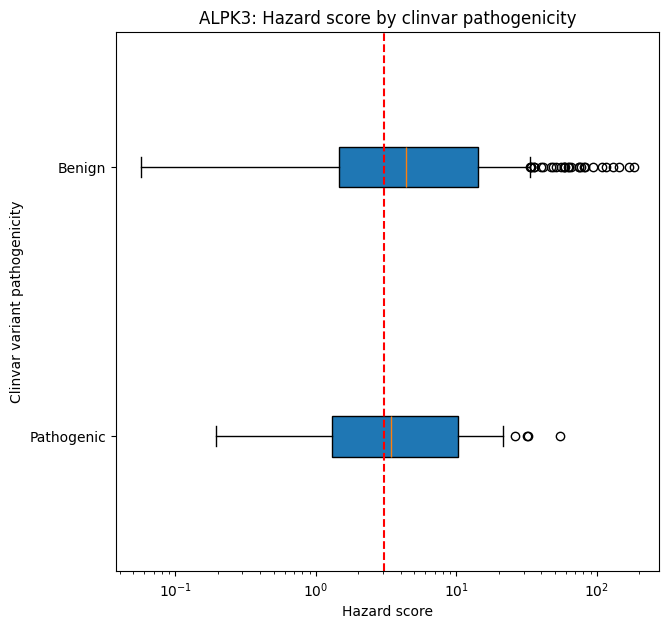

FLNC


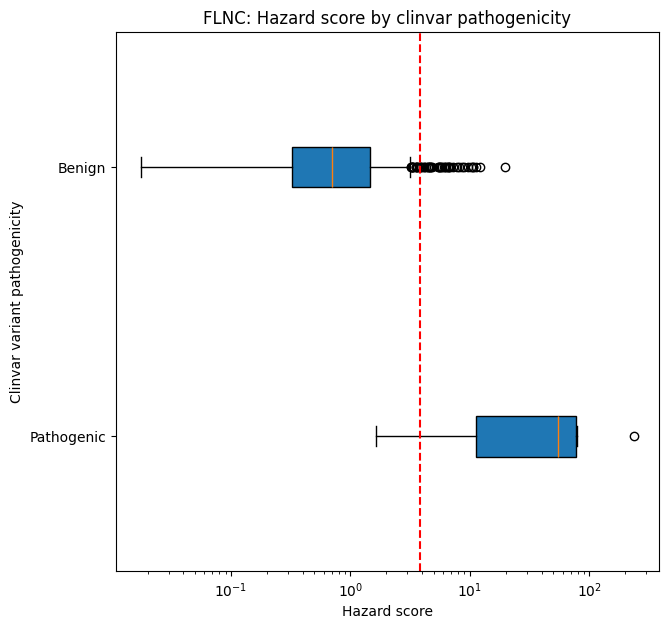

MYBPC3


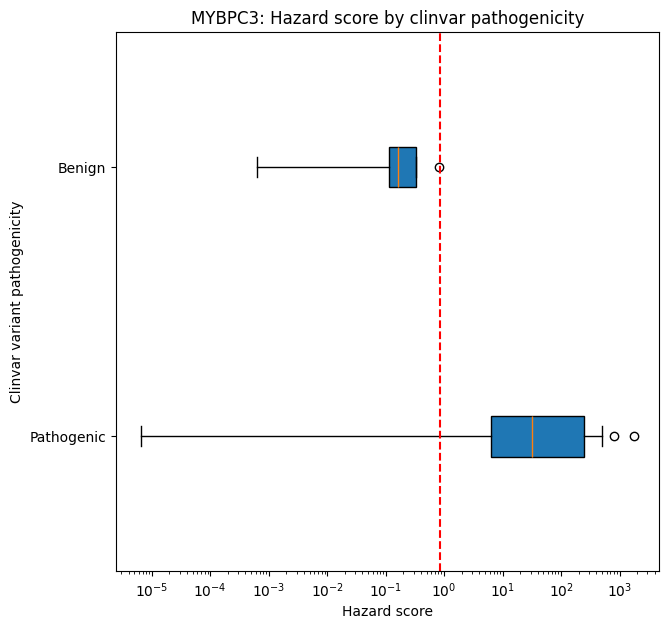

MYH7


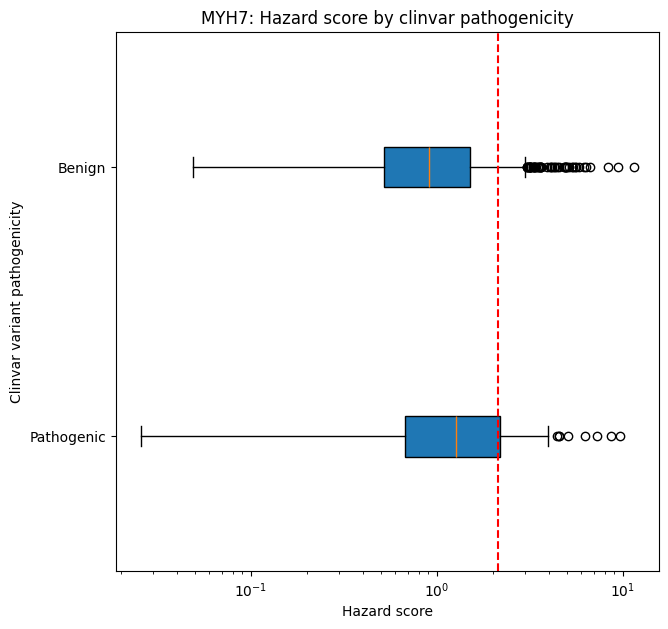

,P-value,Odds ratio,Thresholds,F1 scores
ALPK3,0.001364,4.175291,71,0.280899
FLNC,0.001651,5.147560,85,0.666667
MYBPC3,0.001996,5.426730,38,0.829114
MYH7,0.000893,3.138219,78,0.414634


In [48]:
updated_p_dict, hazard_ratios, f1_scores = find_threshold_vals(thresholds_by_f1_score)
p_vals = pd.DataFrame.from_dict(updated_p_dict, orient = 'index')
p_vals.columns = ["P-value"]
hazard_ratios = pd.DataFrame.from_dict(hazard_ratios, orient = "index")
hazard_ratios.columns = ["Odds ratio"]
f1_scores = pd.DataFrame.from_dict(f1_scores, orient = 'index')
f1_scores.columns = ["F1 scores"]
thresholds = pd.DataFrame.from_dict(thresholds_by_f1_score, orient = 'index')
thresholds.columns = ["Thresholds"]
df = p_vals.join(hazard_ratios).join(thresholds).join(f1_scores)
df